In [1]:
import sys
sys.path.append("..")
from config import Params

In [7]:
import pandas as pd
import numpy as np
import os
import plotly.express as px
import seaborn as sns

In [26]:
class Model:
    
    
    def __init__(self,
                 country_out_scope,
                 conceptual_cols,
                 scale_7,                 
                ):
        self.country_out_scope= country_out_scope
        self.conceptual_cols= conceptual_cols
        self.scale_7= scale_7
                    
    def data_preperation(self):
        #read the data
        df = pd.read_stata(f'..\data\CHES2019V3.dta')
        
        out_scope= self.country_out_scope
        df= df.query('country!=@out_scope')
        
        drop_cols= [x for x in df.columns if '_require' in x] 
        df.drop(drop_cols, axis=1, inplace=True)
        
        return df
        
    def get_concept_dimensions(self, df_prep):
        
        economic= []
        for category in ['econ', 'tax', 'dereg', 'redist']:
            economic+= [x for x in df_prep.columns if (f'{category}' in x) and (x not in self.conceptual_cols)  ]
        
        eu=[x for x in df_prep.columns if ('eu' in x) and (x not in self.conceptual_cols )]
        social= list(set(df_prep.columns)- set(self.conceptual_cols + economic + eu))
    
        feature_dict= { 'eu': eu,
                       'social': social,
                       'economic': economic 
            
        }
        return feature_dict
        
        
    def null_treatment(self, df):
        
        null_cols=df.columns[df.isnull().any()] 
        null_features= [ x for x in null_cols if x not in self.conceptual_cols]
        
        df[self.scale_7] = df[self.scale_7].fillna(4)

        scale_10= list(set(null_features) - set(self.scale_7))
        df[scale_10] =  df[scale_10].fillna(6)
        
        return df
    
    def two_d_visual(self, df, feature_dict):
        
        from sklearn.preprocessing import StandardScaler
        from sklearn.decomposition import PCA
        
        components_weight_dict= {}
        all_features = feature_dict['social'] + feature_dict['eu'] + feature_dict['economic']
        X= data_treated.set_index('party_id')[all_features]

        scaler = StandardScaler()
        scaler.fit(X)
        X_std= pd.DataFrame(scaler.transform(X))
        X_std.columns= X.columns

        X_pca= pd.DataFrame(index= X.index)
        pca = PCA(n_components=1, random_state=42)
        X_pca['component_economic'] = pca.fit_transform(X_std[feature_dict['economic']])
        
        components_weight_dict['economic'] = pca.components_

        X_pca['component_social_eu']= pca.fit_transform(X_std[feature_dict['eu']+ feature_dict['social']])
        
        components_weight_dict['social_eu'] = pca.components_
        
        fig = px.scatter(X_pca.merge(df, on='party_id',how='left'),
                         x="component_economic", 
                         y="component_social_eu",  
                         color= 'country', 
                         text= 'party', 
                         title= "2D representation of CHES data"
        )
        fig.update_layout(width= 1000, height= 750, plot_bgcolor='rgba(0,0,0,0)' )
        fig.update_traces(textposition= 'top center', textfont_size= 9)
        
        if not os.path.exists("images"):
            os.mkdir("images")
        fig.write_image("images\two_dimensional_representation.png")
        
        sns.jointplot(data=X_pca, 
                      x="component_economic",
                      y="component_social_eu", 
                      kind="kde"
        )
        
        return components_weight_dict 

In [32]:
os.getcwd()

'C:\\Users\\PC\\Desktop\\fourkind\\model'

In [27]:
model= Model(Params.country_out_scope, Params.conceptual_cols, Params.scale_7)

In [28]:
data= model.data_preperation()

C:\Users\PC\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [29]:
dct= model.get_concept_dimensions(data)

In [30]:
data_treated= model.null_treatment(data)

In [31]:
model.two_d_visual(data_treated, dct)

ValueError: 
The orca executable is required to export figures as static images,
but it could not be found on the system path.

Searched for executable 'orca' on the following path:
    C:\Users\PC\anaconda3
    C:\Users\PC\anaconda3\Library\mingw-w64\bin
    C:\Users\PC\anaconda3\Library\usr\bin
    C:\Users\PC\anaconda3\Library\bin
    C:\Users\PC\anaconda3\Scripts
    C:\Users\PC\anaconda3\bin
    C:\Users\PC\anaconda3\condabin
    C:\Program Files (x86)\Common Files\Oracle\Java\javapath
    C:\Windows\system32
    C:\Windows
    C:\Windows\System32\Wbem
    C:\Windows\System32\WindowsPowerShell\v1.0
    C:\Windows\System32\OpenSSH
    C:\Program Files\Git\cmd
    C:\Program Files\Docker\Docker\resources\bin
    C:\ProgramData\DockerDesktop\version-bin
    C:\Program Files\Java\jdk1.8.0_201\bin
    C:\spark\spark-2.3.2-bin-hadoop2.7\bin
    C:\Users\PC\AppData\Local\Microsoft\WindowsApps
    .

If you haven't installed orca yet, you can do so using conda as follows:

    $ conda install -c plotly plotly-orca

Alternatively, see other installation methods in the orca project README at
https://github.com/plotly/orca

After installation is complete, no further configuration should be needed.

If you have installed orca, then for some reason plotly.py was unable to
locate it. In this case, set the `plotly.io.orca.config.executable`
property to the full path of your orca executable. For example:

    >>> plotly.io.orca.config.executable = '/path/to/orca'

After updating this executable property, try the export operation again.
If it is successful then you may want to save this configuration so that it
will be applied automatically in future sessions. You can do this as follows:

    >>> plotly.io.orca.config.save()

If you're still having trouble, feel free to ask for help on the forums at
https://community.plot.ly/c/api/python


In [163]:
country_out_scope= ['tur','nor','ice','swi']
df= df.query('country!=@country_out_scope')

In [16]:
conceptual_cols= ['country','eastwest','party_id','party']
drop_cols= [x for x in df.columns if '_require' in x]


economic= []
for category in ['econ', 'tax', 'dereg', 'redist']:
    economic+= [x for x in df.columns if (f'{category}' in x) and (x not in conceptual_cols+drop_cols)  ]
economic

['lrecon',
 'lrecon_sd',
 'lrecon_salience',
 'lrecon_dissent',
 'lrecon_blur',
 'econ_interven',
 'spendvtax',
 'deregulation',
 'redistribution',
 'redist_salience']

In [185]:
eu=[x for x in df.columns if ('eu' in x) and (x not in conceptual_cols+drop_cols) ]
social= list(set(df.columns)- set(conceptual_cols+ drop_cols+ economic+eu))

In [165]:
import plotly.express as px

for i in economic:
    fig = px.box(df, y=i)
    fig.show()

In [169]:
null_columns=df.columns[df.isnull().any()]
null_features= [ x for x in null_columns if x in social+economic+eu]

scale_7= ['eu_cohesion','eu_foreign','eu_intmark','eu_budgets','eu_asylum']

df[scale_7] = df[scale_7].fillna(4)

scale_10= list(set(null_features) - set(scale_7))
df[scale_10] =  df[scale_10].fillna(6)

In [172]:
from sklearn.preprocessing import StandardScaler

X= df.set_index('party_id')[social+eu+economic]

scaler = StandardScaler()
scaler.fit(X)
X_std= pd.DataFrame(scaler.transform(X))
X_std.columns= X.columns

X_pca= pd.DataFrame(index= X.index)

pca = PCA(n_components=1, random_state=42)
X_pca['component_economic'] = pca.fit_transform(X_std[economic])
comp= pca.components_
print(pca.explained_variance_ratio_)
X_pca['component_social_eu']= pca.fit_transform(X_std[social + eu])
print(pca.explained_variance_ratio_)

In [107]:
X_std.loc[0]

,sociallifestyle,multiculturalism,corrupt_salience,multicult_dissent,protectionism,antielite_salience,environment,lrgen,galtan_salience,people_vs_elite,ethnic_minorities,civlib_laworder,religious_principles,galtan_blur,nationalism,immigrate_policy,multicult_salience,urban_rural,anti_islam_rhetoric,regions,galtan,enviro_salience,galtan_dissent,members_vs_leadership,immigrate_salience,immigrate_dissent,galtan_sd,russian_interference,eu_position,eu_position_sd,eu_salience,eu_dissent,eu_blur,eu_cohesion,eu_foreign,eu_intmark,eu_budgets,eu_asylum,lrecon,lrecon_sd,lrecon_salience,lrecon_dissent,lrecon_blur,econ_interven,spendvtax,deregulation,redistribution,redist_salience
0,-0.814198,-0.900988,-1.061410,0.743146,0.523709,-0.850971,-0.312041,-1.322207,-1.547682,-0.728298,-0.788209,-0.787072,-1.018386,-0.089593,-0.610516,-0.776436,-0.567101,-0.672776,-0.325644,0.866798,-0.753344,-0.201385,-0.226923,0.356924,-0.843376,0.485778,-0.069136,-1.189959,0.674066,-1.413453,-1.033452,0.099433,-0.687872,0.811077,0.990202,-0.154971,0.347489,1.161231,-1.260566,-1.030772,1.258510,-0.528127,-1.457774,-1.381986,-1.163586,-1.240826,-1.352857,1.439701
1,-0.847182,-0.802736,-1.176808,0.972709,0.247411,-0.886105,-0.429154,-0.896308,-1.141822,-0.632299,-0.860534,-0.552251,-0.978926,-0.072724,-0.752257,-0.518974,-0.248858,-0.845556,-0.281650,0.467401,-0.815641,-0.201385,-0.226923,-0.027120,-0.709321,1.029701,-0.449947,-1.189959,0.625725,-1.059576,-1.089695,-0.073948,-0.946483,0.604580,0.990202,-0.154971,0.619091,1.083848,-0.861600,-1.212182,1.088959,-0.528127,-1.290230,-1.168481,-0.854994,-1.149112,-1.147312,1.381190
2,-1.177022,-1.425003,-0.869081,0.130977,0.293461,-0.745566,-2.158514,-1.322207,0.033591,0.471695,-1.041348,-1.231997,-0.860547,-0.772785,-1.261370,-1.323542,0.281549,-1.467561,-0.017685,0.966648,-1.438606,2.128704,-1.163049,-1.665707,0.095011,-0.488223,-0.995949,-1.189959,0.964109,-0.832112,-0.695996,-0.073948,-1.109816,0.604580,1.146269,-0.154971,0.709625,1.470768,-1.140877,-0.549488,-0.041377,0.348039,-0.955144,-1.083078,-1.086438,-1.240826,-1.188421,0.620555
3,-1.210006,-1.359501,-1.022944,0.130977,0.339510,-0.780701,-2.201455,-1.180241,0.133737,0.471695,-1.041348,-1.198010,-0.900007,-0.747482,-1.197731,-1.226994,0.228509,-1.415727,-0.061679,0.916723,-1.407458,2.192252,-1.163049,-1.614501,-0.128415,-0.424976,-0.929702,-1.189959,0.964109,-0.832112,-0.695996,-0.073948,-1.191483,0.501331,1.146269,-0.154971,0.709625,1.470768,-1.061083,-0.578249,-0.041377,0.055983,-0.955144,-0.997676,-1.009290,-1.149112,-1.023986,0.620555
4,-0.550327,-0.180468,-1.176808,1.508357,-1.272227,-1.026644,0.601436,0.558850,-1.231427,-0.056302,-0.064953,-0.119685,-0.900007,0.138138,-0.656799,0.060315,-0.726224,-0.096845,-0.237656,1.116422,-0.654236,-0.455577,-0.851007,0.075292,-0.619951,1.320636,-0.697518,-1.189959,0.915768,-0.422877,-0.527267,-0.420711,-0.946483,0.191585,1.224303,0.722359,1.252828,1.238615,0.973646,-0.556628,1.201993,-0.382099,-1.374002,1.009277,0.957983,1.006156,0.743701,-0.081571
5,-0.814198,-0.213219,-1.215274,1.814442,-1.364327,-1.026644,0.589724,0.594341,-0.735962,0.519694,-0.101116,-0.076428,-0.978926,-0.275152,-0.784077,0.189046,-0.567101,-0.557590,-0.281650,0.667100,-0.926076,-0.455577,-0.851007,-0.129531,-0.619951,1.409181,-0.465808,-1.189959,1.109131,-1.155035,-0.527267,-0.767474,-1.191483,-0.221409,1.224303,0.802116,1.252828,1.315999,1.093336,-0.668021,1.258510,-0.236072,-1.374002,1.094679,1.189427,1.235439,0.825919,-0.081571
6,0.076369,-0.469272,-1.215274,0.870681,-0.272950,-1.026644,-0.168904,-0.257458,-0.851922,-0.344301,-0.209604,-0.267993,0.717848,0.289958,-0.367530,-0.358060,-0.514061,0.709458,-0.468625,0.757872,0.025362,-0.137838,0.085120,-0.093687,-1.074926,0.990171,-0.559292,-1.189959,0.867428,-0.117728,-0.977210,-0.189536,-0.701483,0.088337,1.380370,0.403330,1.524430,1.161231,-0.103564,-0.980157,0.071657,1.078176,-0.452515,-0.015550,0.263651,0.032973,-0.201806,-0.140081
7,0.406208,-0.049464,-1.215274,1.814442,-0.424914,-1.096913,

In [160]:
[ str(y)+ ": "+ str(round(x/ df.query('country!=@country_out_scope').shape[0]*100,1))+'%' for x, y in zip(list(df.query('country!=@country_out_scope').isnull().sum()),df.query('country!=@country_out_scope').isnull().sum().index)  ]

['country: 0.0%',
 'eastwest: 0.0%',
 'party: 0.0%',
 'party_id: 0.0%',
 'eu_position: 0.0%',
 'eu_position_sd: 0.0%',
 'eu_salience: 0.0%',
 'eu_dissent: 0.8%',
 'eu_blur: 0.4%',
 'eu_cohesion: 0.0%',
 'eu_foreign: 0.4%',
 'eu_intmark: 0.0%',
 'eu_budgets: 0.4%',
 'eu_asylum: 0.4%',
 'lrgen: 0.0%',
 'lrecon: 0.0%',
 'lrecon_sd: 0.0%',
 'lrecon_salience: 0.0%',
 'lrecon_dissent: 0.8%',
 'lrecon_blur: 1.2%',
 'galtan: 0.0%',
 'galtan_sd: 0.0%',
 'galtan_salience: 0.0%',
 'galtan_dissent: 3.2%',
 'galtan_blur: 0.8%',
 'immigrate_policy: 0.0%',
 'immigrate_salience: 0.0%',
 'immigrate_dissent: 0.4%',
 'multiculturalism: 0.0%',
 'multicult_salience: 0.4%',
 'multicult_dissent: 0.4%',
 'redistribution: 0.4%',
 'redist_salience: 0.0%',
 'environment: 0.0%',
 'enviro_salience: 0.0%',
 'spendvtax: 0.4%',
 'deregulation: 0.0%',
 'econ_interven: 0.0%',
 'civlib_laworder: 0.4%',
 'sociallifestyle: 0.0%',
 'religious_principles: 0.0%',
 'ethnic_minorities: 0.4%',
 'nationalism: 0.4%',
 'urban_rura

In [126]:
list(comp[0])

[-0.42036635,
 -0.08339169,
 0.09686027,
 -0.10304647,
 -0.10588604,
 -0.41373274,
 -0.41548985,
 -0.41704226,
 -0.4226867,
 0.29787633]

In [128]:
X_pca.component_economic.mean()

4.295040412216622e-08

In [127]:
sum([x*y  for x,y in zip(list(X_std[ economic].loc[2,:]), list(comp[0])) ])

2.690837239535668

In [100]:
X_pca

,component_economic,component_social
party_id,,
102.0,3.519932,-2.781388
103.0,2.974076,-2.751653
104.0,2.690838,-4.383409
105.0,2.514648,-4.359769
106.0,-1.635446,-1.349597
107.0,-1.947913,-1.653410
108.0,-0.004263,-1.065204
109.0,-0.682108,-0.193316
110.0,-2.772205,3.148213


In [96]:
list(X_std.loc[0,:])

[-0.8141981363296509,
 -0.9009883403778076,
 -1.0614100694656372,
 0.7431458830833435,
 0.5237088799476624,
 -0.8509705066680908,
 -0.31204134225845337,
 -1.3222072124481201,
 -1.5476819276809692,
 -0.7282983660697937,
 -0.7882087230682373,
 -0.7870721817016602,
 -1.0183863639831543,
 -0.08959321677684784,
 -0.6105155944824219,
 -0.7764355540275574,
 -0.5671014785766602,
 -0.6727764010429382,
 -0.325643926858902,
 0.8667983412742615,
 -0.7533442974090576,
 -0.20138540863990784,
 -0.22692251205444336,
 0.35692429542541504,
 -0.8433758020401001,
 0.4857781231403351,
 -0.06913627684116364,
 -1.1899585723876953,
 0.6740656495094299,
 -1.4134528636932373,
 -1.0334523916244507,
 0.09943327307701111,
 -0.6878718137741089,
 0.811076819896698,
 0.9902022480964661,
 -0.1549709588289261,
 0.34748902916908264,
 1.161231279373169,
 -1.2605664730072021,
 -1.030772089958191,
 1.2585101127624512,
 -0.5281266570091248,
 -1.4577736854553223,
 -1.381986379623413,
 -1.1635855436325073,
 -1.240825533866882

In [84]:
pca.explained_variance_ratio_

array([0.41560614], dtype=float32)

In [292]:
#df_final['eastwest'].fillna('unknown', inplace =True) 

In [166]:
df.shape

(247, 55)

In [195]:
import plotly.express as px

fig = px.scatter(X_pca.merge(df, on='party_id',how='left'), x="component_economic", y="component_social_eu", trendline= True, color= 'country', text= 'party', title= "2D representation of CHES data")
fig.update_layout(width= 1000, height= 750, plot_bgcolor='rgba(0,0,0,0)' )
fig.update_traces(textposition= 'top center', textfont_size= 9)
fig.show()

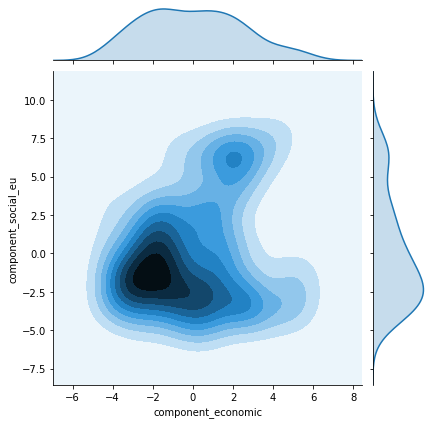

In [181]:
sns.jointplot(data=X_pca, x="component_economic", y="component_social_eu", kind="kde")

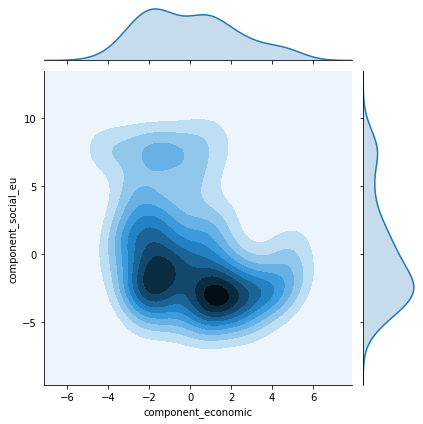

In [179]:
sns.jointplot(data=X_pca, x="component_economic", y="component_social_eu", kind="kde")

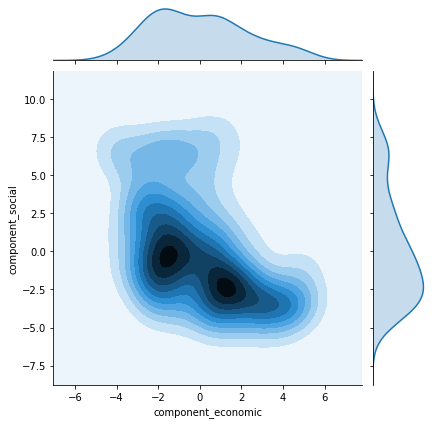

In [82]:
sns.jointplot(data=X_pca, x="component_economic", y="component_social", kind="kde")

In [83]:
np.mean(X_pca[['component_economic','component_social']])

component_economic    4.295040e-08
component_social      1.533943e-08
dtype: float32

In [267]:
import plotly.express as px

fig = px.scatter(df_final, x="component_economic", y="component_social", color= 'country', text= 'party')
fig.update_layout(width= 1200, height= 500, )
fig.update_traces(textposition= 'top center', textfont_size= 9)
fig.show()

In [183]:
import plotly.express as px

fig = px.scatter(df_final, x="component_economic_eu", y="component_social", color= 'eastwest', text= 'party')
fig.update_layout(width= 1200, height= 500, )
fig.update_traces(textposition= 'top center', textfont_size= 9)
fig.show()

In [173]:
import plotly.express as px

fig = px.scatter(df_final, x="component_economic", y="component_social_eu", color= 'eastwest', text= 'party')
fig.update_layout(width= 1200, height= 500, )
fig.update_traces(textposition= 'top center', textfont_size= 9)
fig.show()

In [177]:
fig.show()

In [231]:
from sklearn.decomposition import FactorAnalysis 
X_fa= pd.DataFrame(index= X.index)
fa = FactorAnalysis(n_components=1, random_state=123)
X_fa['component_economic'] = fa.fit_transform(X_std[economic])
X_fa['component_social_eu']= fa.fit_transform(X_std[eu+social])

df_final = X_fa.reset_index().merge(df[['party_id','party', 'country']], on= 'party_id', how='left')
df_final['country']= df_final['country'].cat.add_categories('unknown')
df_final['country'].fillna('unknown', inplace =True) 

fig = px.scatter(df_final, x="component_economic", y="component_social_eu", color= 'country', text= 'party')
fig.update_layout(width= 1200, height= 500, )
fig.update_traces(textposition= 'top center', textfont_size= 9)
fig.show()

In [397]:
import numpy as np
from sklearn.impute import SimpleImputer
imp1 = SimpleImputer( strategy='mean')
imp2 = SimpleImputer(strategy='constant')

X_imp = pd.DataFrame(columns= economic+eu+social)
for i in list(X.index.unique()):
    mask= f'party_id == {i}'
    X_mask= X.query(mask)[economic+eu+social]
    imp1.fit(X_mask)
    imp2.fit(X_mask)

    imp2.transform(imp1.transform(X_mask))
    imputed= imp.fit_transform(X_mask)
    imputed= pd.DataFrame(imputed)
    imputed.columns= economic+eu+social
    X_imp = X_imp.append( imputed)

ValueError: X has 41 features, but this SimpleImputer is expecting 42 features as input.

In [ ]:
conceptual_cols= ['party','party_id', 'dob','party_a_econ','party_b_econ', 'party_c_econ','cname','party_name','id','gender','galtan_self','lrecon_self']
drop_cols= [x for x in df_orig.columns if '_sd' in x]+[x for x in df_orig.columns if '_require' in x]

economic= []
for category in ['econ', 'tax', 'dereg', 'redist']:
    economic+= [x for x in df_orig.columns if (f'{category}' in x) and (x not in conceptual_cols)  ]
economic